In [17]:
import os
import math
import scipy
import imageio
import read_roi
import itertools
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
from natsort import natsorted
import matplotlib.pyplot as plt
from skimage.draw import polygon2mask
from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator

from Analysis_scripts import *

In [2]:
main_path = '/mnt/g/My Drive/MKA/Papers/Sandra/Sandra annotations/'
exp741 = pd.read_pickle(os.path.join(main_path, '2024/Run 0_20240216', 'Experiment741_analyzed_norm.pkl'))
exp807 = pd.read_pickle(os.path.join(main_path, '2024/Run 2', 'Experiment807_analyzed.pkl'))
exp2022 = pd.read_pickle(os.path.join(main_path, '2022_02', 'Experiment807_analyzed_norm.pkl')) # Here the filename was mislabelled
exp811 = pd.read_pickle(os.path.join(main_path, '2024/Run 3', 'Experiment811_analyzed_norm.pkl'))

In [3]:
timepoints = {'exp741': {0: 'ISC',
                         1: 'ISC',
                         2: 'ISC',
                         3: 'ISC',
                         4: 'ISC',
                         5: 'ISC',
                         6: 'ISC',
                         7: 'Border ISC',
                         8: 'Border ISC'},
              'exp807': {0: 'TA',
                         1: 'TA',
                         2: 'TA',
                         3: 'Border ISC',
                         4: 'ISC',
                         5: 'ISC',
                         6: 'ISC',
                         7: 'ISC',
                         8: 'Border ISC',
                         9: 'TA',
                         10: 'TA'},
              'exp2022': {0: 'ISC', 
                          1: 'ISC', 
                          2: 'ISC', 
                          3: 'ISC', 
                          4: 'ISC', 
                          5: 'ISC', 
                          6: 'ISC', 
                          7: 'ISC', 
                          8: 'ISC', 
                          9: 'Border ISC', 
                          10: 'TA', 
                          11: 'TA'},
               'exp811': {0: 'Border ISC', 
                          1: 'ISC', 
                          2: 'Border ISC', 
                          3: 'TA', 
                          4: 'TA', 
                          5: 'TA', 
                          6: 'TA', 
                          7: 'TA', 
                          8: 'TA', 
                          9: 'TA'}}

In [4]:
crypt_side = {'exp741': {0: 'left',
                         1: 'left',
                         2: 'left',
                         3: 'left',
                         4: 'left',
                         5: 'right',
                         6: 'right',
                         7: 'right',
                         8: 'right'},
              'exp807': {0: 'left',
                         1: 'left',
                         2: 'left',
                         3: 'left',
                         4: 'left',
                         5: 'left',
                         6: 'right',
                         7: 'right',
                         8: 'right',
                         9: 'right',
                         10: 'right'},
              'exp2022': {0: 'left', 
                          1: 'left', 
                          2: 'left', 
                          3: 'left', 
                          4: 'left', 
                          5: 'left', 
                          6: 'right', 
                          7: 'right', 
                          8: 'right', 
                          9: 'right', 
                          10: 'right', 
                          11: 'right'},
               'exp811': {0: 'left', 
                          1: 'left', 
                          2: 'right', 
                          3: 'right', 
                          4: 'right', 
                          5: 'right', 
                          6: 'right', 
                          7: 'right', 
                          8: 'right', 
                          9: 'right'}}

In [5]:
exp741['Experiment'] = 'exp741'
exp807['Experiment'] = 'exp807'
exp811['Experiment'] = 'exp811'
exp2022['Experiment'] = 'exp2022'

#comb_df = pd.concat([exp741.reset_index(), exp807.reset_index(), exp811.reset_index()], ignore_index = True)
comb_df = pd.concat([exp741.reset_index(), exp807.reset_index(), exp811.reset_index(), exp2022.reset_index()], ignore_index = True)
comb_df['timepoint'] = comb_df['ImageNumber']*2
comb_df['last_timepoint'] = comb_df['Experiment'].map(comb_df.groupby('Experiment')['timepoint'].max().to_dict())
comb_df['shared_last_timepoint'] = comb_df.groupby('Experiment')['timepoint'].max().min()
comb_df['Cell_type'] = comb_df.apply(lambda row: timepoints[row['Experiment']][row['Ordered_Number']], axis=1)
comb_df['Crypt_side'] = comb_df.apply(lambda row: crypt_side[row['Experiment']][row['Ordered_Number']], axis=1)

dist = 'distance_fraction_bisect_to_roi'
comb_df[dist] = comb_df[dist]*comb_df['side_of_cell']
for intensity_cutoff in [1, 2, 3]:
    comb_df[f'{dist}_cutoff{intensity_cutoff}'] = comb_df.apply(lambda row: row[dist][row['intensities']>intensity_cutoff], axis = 1)

#Normalize the cell intensity fraction values to the cell location along the crypt. Make it so that the positive values are pointing out of the crypt
cols = ['distance_fraction_bisect_to_roi', 'distance_fractions_by_intensity', 'distances_filtered_cutoff1', 'distances_filtered_cutoff2', 'distances_filtered_cutoff3', 'distance_fraction_bisect_to_roi_cutoff1', 'distance_fraction_bisect_to_roi_cutoff2', 'distance_fraction_bisect_to_roi_cutoff3']
for col in cols:
    comb_df[f'CryptSideNormalized_{col}'] = comb_df.apply(lambda row: row[col]*-1 if row['Crypt_side'] == 'left' else row[col], axis = 1)

comb_df

,ImageNumber,Ordered_Number,Lumen,BM,Roi_name,Roi_centroid,Roi_coords,Angle,Center,Patches,...,distance_fraction_bisect_to_roi_cutoff2,distance_fraction_bisect_to_roi_cutoff3,CryptSideNormalized_distance_fraction_bisect_to_roi,CryptSideNormalized_distance_fractions_by_intensity,CryptSideNormalized_distances_filtered_cutoff1,CryptSideNormalized_distances_filtered_cutoff2,CryptSideNormalized_distances_filtered_cutoff3,CryptSideNormalized_distance_fraction_bisect_to_roi_cutoff1,CryptSideNormalized_distance_fraction_bisect_to_roi_cutoff2,CryptSideNormalized_distance_fraction_bisect_to_roi_cutoff3
0,1,0,"(0.9100201206351528, 50.358073677982844)","(0.910020120635096, -53.87723703772424)",1__0001-0288-0180,"(0.0, 0.0)","[[5.908326322465115, -56.88005822999449], [5.0...",2.652200,"(0.9100201206351244, -1.7595816798707062)","Polygon314((5.90833, -56.8801) ...)",...,"[1.0, -0.030141170890492657, -1.0, 1.0, -0.431...","[1.0, -0.030141170890492657, -0.43150829681575...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.574902...",[],"[-0.582067668019254, -0.582067668019254, -0.73...","[-1.0, -1.0, -1.0, -1.0, 0.030141170890492657,...","[-1.0, -1.0, -1.0, -1.0, 0.030141170890492657,...","[-0.582067668019254, -0.7310742285548409, -0.4...","[-1.0, 0.030141170890492657, 1.0, -1.0, 0.4315...","[-1.0, 0.030141170890492657, 0.431508296815753..."
1,1,1,"(9.244888081862797, 54.47515117386436)","(9.244888081862797, -53.33950460168407)",1__0001-0311-0158,"(0.0, 0.0)","[[-0.4198462022150977, 48.854393999055134], [-...",2.434978,"(9.244888081862797, 0.567823286090146)","Polygon306((-0.419846, 48.8544) ...)",...,"[0.8961281170436507, 0.8009709830458761, 0.437...","[0.3684721397233441, 0.4932025226358081, 0.277...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.908586...",[],"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.815958...","[-0.8961281170436507, -0.8961281170436507, -0....","[-0.3684721397233441, -0.3684721397233441, -0....","[-1.0, -1.0, -1.0, -0.8159581400270943, -0.845...","[-0.8961281170436507, -0.8009709830458761, -0....","[-0.3684721397233441, -0.4932025226358081, -0...."
2,1,2,"(-5.753818258072499, 50.509033457196395)","(-5.753818258072556, -44.06897667200859)",1__0344-0144,"(0.0, 0.0)","[[-6.331833929440506, 48.17585905559879], [-6....",2.796435,"(-5.753818258072528, 3.2200283925939033)","Polygon881((-6.33183, 48.1759) ...)",...,"[0.5903383787707704, 0.3604958595284636, 0.937...","[0.5903383787707704, 0.5060010238366127, 0.963...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0....",[],"[-0.579388084606299, -0.579388084606299, -0.51...","[-0.5903383787707704, -0.5903383787707704, -0....","[-0.5903383787707704, -0.5903383787707704, -0....","[-0.579388084606299, -0.514350542594269, -0.42...","[-0.5903383787707704, -0.3604958595284636, -0....","[-0.5903383787707704, -0.5060010238366127, -0...."
3,1,3,"(3.8291868089456784, 53.67923652934299)","(3.8291868089456784, -38.10856222408611)",1__0383-0144,"(0.0, 0.0)","[[-2.7582274749076987, 48.02309417700626], [-2...",-3.010481,"(3.82918680894565, 7.785337152628443)","Polygon839((-2.75823, 48.0231) ...)",...,"[0.4105246476894528, 0.5780473319222833, -0.12...","[-0.3891955020565169, 0.906103217766548, -0.10...","[-0.6423764397176649, -0.7102679870146493, -0....",[],"[-0.35505939011965687, -0.35505939011965687, 0...","[-0.4105246476894528, -0.4105246476894528, -0....","[0.3891955020565169, 0.3891955020565169, 0.389...","[-0.35505939011965687, 0.9682113392347443, -0....","[-0.4105246476894528, -0.5780473319222833, 0.1...","[0.3891955020565169, -0.906103217766548, 0.107..."
4,1,4,"(-0.9836684477864992, 52.60010683791464)","(-0.9836684477865276, -39.85528781269512)",1__0001-0429-0160,"(0.0, 0.0)","[[-5.829248326526937, 51.367079815199446], [-5...",-2.463473,"(-0.9836684477865276, 6.372409512609764)","Polygon276((-5.82925, 51.3671) ...)",...,"[-1.0, -1.0, -0.8600922423877084, -0.919159378...","[-1.0, -0.8600922423877084, -0.940946784445334...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.911...",[],"[1.0, 1.0, 1.0, 1.0, 1.0, 

# Calculate distances from center

Since the centroid is set to be at coordinate origin (0, 0), then we can consider just the y-coordinates of the cells for the apical distance measurements

But we need to normalize the cells to be the same lenght based on the bisecting line distance

In [6]:
comb_df['scaled_y_coordinates'] = comb_df.apply(lambda row: min_max_scale_roi_y_coordinates(row['coordinates_in_roi']), axis = 1)
for cutoff_value in [0, 1, 2, 3]:
    comb_df[f'scaled_y_coordinates_intensityCutoff{cutoff_value}'] = comb_df.apply(lambda row: row['scaled_y_coordinates'][row['intensities']>cutoff_value], axis = 1)

# Sanity check

## ROI locations

ax = axes[ix // ncols, ix % ncols]


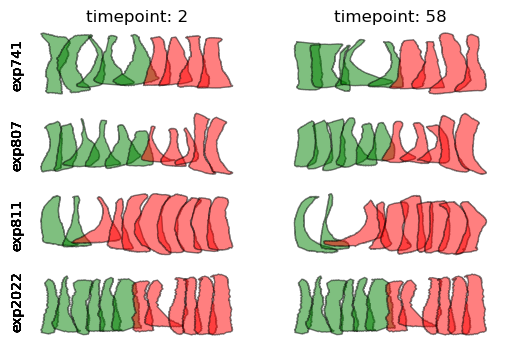

In [7]:
experiments = comb_df['Experiment'].unique()
fig, axes = initialize_subplots(len(experiments)*2, ncols = 2, figsize_multiplier=(3, 1))

for row, exp in enumerate(experiments):
    for col, timepoint in enumerate([2, 58]):
        ax = axes[row, col]
        tmp = comb_df.query('Experiment == @exp & timepoint == @timepoint')
        for group in tmp['Ordered_Number'].unique():
            color = 'green' if tmp.query('Ordered_Number == @group')['Crypt_side'].values == 'left' else 'red'
            polygon = mpl.patches.Polygon(tmp.query('Ordered_Number == @group')['Roi_coords_shifted_side_by_side'].values[0], ec = 'k', fc = color, closed = True, fill = True, alpha = 0.5)
            ax.add_patch(polygon)
            #ax.add_patch(tmp.query('Ordered_Number == @group')['Patches'].values[0])
            if row == 0:
                ax.set_title(f'timepoint: {timepoint}')
            if col == 0:
                ax.text(x = -0.1, y = 0.1, s = exp, va = 'bottom', rotation = 90, transform=ax.transAxes)
        ax.autoscale()
        ax.set_axis_off()

ax = axes[ix // ncols, ix % ncols]


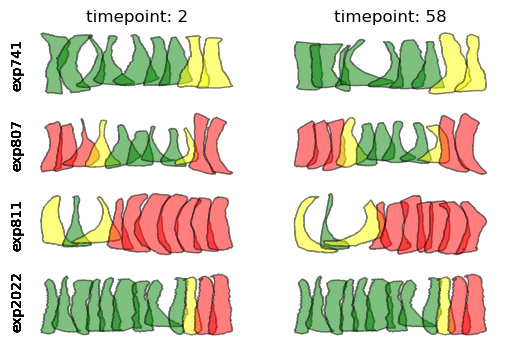

In [8]:
experiments = comb_df['Experiment'].unique()
fig, axes = initialize_subplots(len(experiments)*2, ncols = 2, figsize_multiplier=(3, 1))

colors = {'ISC': 'green', 'Border ISC': 'yellow', 'TA': 'red'}

for row, exp in enumerate(experiments):
    for col, timepoint in enumerate([2, 58]):
        ax = axes[row, col]
        tmp = comb_df.query('Experiment == @exp & timepoint == @timepoint')
        for group in tmp['Ordered_Number'].unique():
            color = colors[tmp.query('Ordered_Number == @group')['Cell_type'].values[0]]
            polygon = mpl.patches.Polygon(tmp.query('Ordered_Number == @group')['Roi_coords_shifted_side_by_side'].values[0], ec = 'k', fc = color, closed = True, fill = True, alpha = 0.5)
            ax.add_patch(polygon)
            #ax.add_patch(tmp.query('Ordered_Number == @group')['Patches'].values[0])
            if row == 0:
                ax.set_title(f'timepoint: {timepoint}')
            if col == 0:
                ax.text(x = -0.1, y = 0.1, s = exp, va = 'bottom', rotation = 90, transform=ax.transAxes)
        ax.autoscale()
        ax.set_axis_off()

# Normalized distance from the center of the bisecting line

Use the combination of the normalized y coords together with the CryptSideNormalized_distance_fraction_bisect_to_roi values to construct essentially a linear coordinate grid for distance measurements

In [9]:
comb_df['Normalized_xy_coordinate_in_roi'] = list(zip(*[comb_df['CryptSideNormalized_distance_fraction_bisect_to_roi'], comb_df['scaled_y_coordinates']]))

#Calculate euclidean distance from the bisect center
comb_df['Normalized_xy_distances_from_bisect_center'] = comb_df.apply(lambda row: np.linalg.norm(row['Normalized_xy_coordinate_in_roi'], axis=0), axis = 1)
comb_df['xy_distances_from_bisect_center'] = comb_df.apply(lambda row: np.linalg.norm(np.abs(row['coordinates_in_roi'])-[np.mean(row['bisecting_line'], axis = 0)[0], 0], axis=1), axis = 1)

#Filter values based on intensity cutoffs
for cutoff_value in [0, 1, 2, 3]:
    comb_df[f'Normalized_xy_distances_from_bisect_center_IntensityCutoff{cutoff_value}'] = comb_df.apply(lambda row: row['Normalized_xy_distances_from_bisect_center'][row['intensities']>cutoff_value], axis = 1)
    comb_df[f'xy_distances_from_bisect_center_IntensityCutoff{cutoff_value}'] = comb_df.apply(lambda row: row['xy_distances_from_bisect_center'][row['intensities']>cutoff_value], axis = 1)

# Combine first and last 10 timepoints

In [15]:
cutoff_value = 2
values = f'CryptSideNormalized_distance_fraction_bisect_to_roi_cutoff{cutoff_value}'

df = comb_df[values].explode().reset_index()
df[['Ordered_Number', 'timepoint', 'Cell_type', 'Experiment']] = comb_df.loc[df['index'], ['Ordered_Number', 'timepoint', 'Cell_type', 'Experiment']].values
#df = df.melt(id_vars = ['Ordered_Number', 'timepoint', 'Cell_type', 'Experiment'], value_vars = values, var_name = 'Intensity', value_name = values).dropna(how = 'any', axis = 0)
df[values] = df[values].astype('float64')
df['time_group'] = ['beginning' if t < 16 else 'end' if t > 42 else 'middle' for t in df['timepoint']]
df = df.dropna(how = 'any', axis = 0)
df['color_density'] = df.groupby(by = ['Cell_type', 'time_group'])[values].transform(calc_density_1d)

df

,index,CryptSideNormalized_distance_fraction_bisect_to_roi_cutoff2,Ordered_Number,timepoint,Cell_type,Experiment,time_group,color_density
0,0,-1.000000,0,2,ISC,exp741,beginning,0.152687
1,0,0.030141,0,2,ISC,exp741,beginning,0.036875
2,0,1.000000,0,2,ISC,exp741,beginning,0.582677
3,0,-1.000000,0,2,ISC,exp741,beginning,0.152687
4,0,0.431508,0,2,ISC,exp741,beginning,0.460332
...,...,...,...,...,...,...,...,...
187226,1250,-0.764283,11,60,TA,exp2022,end,0.982234
187227,1250,-0.110474,11,60,TA,exp2022,end,0.900787
187228,1250,-0.529427,11,60,TA,exp2022,end,0.936389
187229,1250,-0.650361,11,60,TA,exp2022,end,0.938606


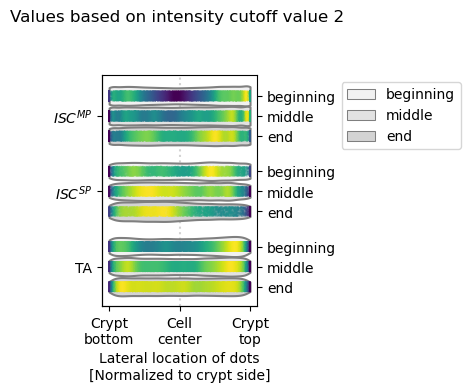

In [18]:
violin_palette = 'Greys'
order = ['ISC', 'Border ISC', 'TA']
time_group_order = ['beginning', 'middle', 'end']
point_order = itertools.product(order, time_group_order)

fig, ax = plt.subplots(figsize = (2, 3))
sbn.violinplot(data = df, y = 'Cell_type', x = values, cut = 0, order = order, hue = 'time_group', hue_order = time_group_order, 
               split = False, inner = None, ax = ax, color = 'lightgray', orient = 'horizontal', scale = 'area')
#sbn.stripplot(data = df, x = 'Cell_type', y = values, hue = 'Frame', order = ['ISC', 'TA'], ax = ax, color = 'k', s = 0.5, dodge = 0.5, jitter = 0.2)
xs = [violin.get_paths()[0].vertices[:, 1].mean() for violin in ax.collections]

x_ix = 0
for cell, time in point_order:
    #print(cell, time, xs[x_ix])
    tmp_df = df.query('Cell_type == @cell & time_group == @time')
    y = tmp_df[values].values
    x = [xs[x_ix]]*len(y)
    magnitude = 800
    x += (np.random.randint(0, 100, size = len(y))-100/2)/magnitude
    c = tmp_df['color_density'].values
    ax.scatter(x = y, y = x, c = c, s = 0.01)
    x_ix+=1
    
[ax.spines[spine].set_visible(False) for spine in ['top', 'right']]

ax.set_xticks([-1, 0, 1], ['Crypt\nbottom', 'Cell\ncenter', 'Crypt\ntop'])
ax.set_yticklabels(['$ISC^{MP}$', '$ISC^{SP}$', 'TA'])
ax.axvline(0, ls = ':', zorder = -10, c = 'lightgray')
ax.set_ylabel('')
ax.set_xlabel('Lateral location of dots\n[Normalized to crypt side]')

twinx = ax.twinx()
twinx.set_ylim(ax.get_ylim())
twinx.set_yticks(np.array(xs), labels = np.array([time_group_order]*len(order)).flatten())

fig.suptitle(f'Values based on intensity cutoff value {cutoff_value}', y = 1.1)
ax.legend(bbox_to_anchor = (1.5,1))
#fig.savefig(os.path.join(main_path, 'Figures', f'Lateral_cutoff2_CombinedTime_3groups_horizontal_dotsWithDensity.pdf'), bbox_inches = 'tight')

# Stats

## Lateral differences

### Mann-Whitney U-test

Not appropriate here since it compares central tendencies of 2 distributions. Not useful for the bimodal distribution we see here

In [20]:
res = {}
for cell in natsorted(df['Cell_type'].unique()):
    res[cell] = {}
    first = list(df.query('Cell_type == @cell & time_group == "beginning"')[values].values)
    last = list(df.query('Cell_type == @cell & time_group == "end"')[values].values)
    stat, pval = scipy.stats.mannwhitneyu(first, last)
    res[cell][time] = f'{pval:.3f}' if pval > 0.001 else f'{pval:.1e}'

pd.DataFrame.from_dict(res)[['ISC','Border ISC', 'TA']]

,ISC,Border ISC,TA
end,0.969,5.2e-11,2.8e-05


In [21]:
res = {}
comparisons = itertools.combinations(df['Cell_type'].unique(), r = 2)
for c1, c2 in comparisons:
    res[(c1, c2)] = {}
    for time in ['beginning', 'middle', 'end']:
        first = list(df.query('Cell_type == @c1 & time_group == @time')[values].values)
        last = list(df.query('Cell_type == @c2 & time_group == @time')[values].values)
        stat, pval = scipy.stats.mannwhitneyu(first, last)
        res[(c1, c2)][time]=f'{pval:.3f}' if pval > 0.001 else f'{pval:.1e}'
        print(f'{c1} vs {c2}, {time}:', f'{pval:.3f}' if pval > 0.001 else f'{pval:.1e}')
        #res[f'{time}_{c1}_vs_{c2}'] = f'{pval:.3f}' if pval > 0.001 else f'{pval:.1e}'

pd.DataFrame.from_dict(res, orient = 'index').reset_index()

ISC vs Border ISC, beginning: 0.638
ISC vs Border ISC, middle: 2.4e-05
ISC vs Border ISC, end: 3.2e-15
ISC vs TA, beginning: 0.769
ISC vs TA, middle: 0.001
ISC vs TA, end: 2.9e-05
Border ISC vs TA, beginning: 0.734
Border ISC vs TA, middle: 0.032
Border ISC vs TA, end: 5.5e-08


,level_0,level_1,beginning,middle,end
0,ISC,Border ISC,0.638,2.4e-05,3.2e-15
1,ISC,TA,0.769,0.001,2.9e-05
2,Border ISC,TA,0.734,0.032,5.5e-08


### Kruskal-Wallis test for 2 groups

Tests if 2 distributions come from the same distribution

In [23]:
res = {}
comparisons = itertools.combinations(df['Cell_type'].unique(), r = 2)
for c1, c2 in comparisons:
    res[(c1, c2)] = {}
    for time in ['beginning', 'middle', 'end']:
        first = list(df.query('Cell_type == @c1 & time_group == @time')[values].values)
        last = list(df.query('Cell_type == @c2 & time_group == @time')[values].values)
        stat, pval = scipy.stats.ks_2samp(first, last)
        res[(c1, c2)][time]=f'{pval:.3f}' if pval > 0.001 else f'{pval:.1e}'

pd.DataFrame.from_dict(res, orient = 'index').reset_index()

ISC vs Border ISC, beginning: 5.2e-04
ISC vs Border ISC, middle: 5.2e-09
ISC vs Border ISC, end: 1.3e-20
ISC vs TA, beginning: 1.6e-31
ISC vs TA, middle: 1.7e-47
ISC vs TA, end: 2.1e-29
Border ISC vs TA, beginning: 6.6e-12
Border ISC vs TA, middle: 7.2e-06
Border ISC vs TA, end: 5.2e-10


,level_0,level_1,beginning,middle,end
0,ISC,Border ISC,5.2e-04,5.2e-09,1.3e-20
1,ISC,TA,1.6e-31,1.7e-47,2.1e-29
2,Border ISC,TA,6.6e-12,7.2e-06,5.2e-10


## Longitudinal differences

In [29]:
cutoff_value = 2
values = f'scaled_y_coordinates_intensityCutoff{cutoff_value}'

df = comb_df[values].explode().reset_index()
df[['Ordered_Number', 'timepoint', 'Cell_type', 'Experiment']] = comb_df.loc[df['index'], ['Ordered_Number', 'timepoint', 'Cell_type', 'Experiment']].values
#df = df.melt(id_vars = ['Ordered_Number', 'timepoint', 'Cell_type', 'Experiment'], value_vars = values, var_name = 'Intensity', value_name = values).dropna(how = 'any', axis = 0)
df[values] = df[values].astype('float64')
df['time_group'] = ['beginning' if t < 16 else 'end' if t > 42 else 'middle' for t in df['timepoint']]
df = df.dropna(how = 'any', axis = 0)
df['color_density'] = df.groupby(by = ['Cell_type', 'time_group'])[values].transform(calc_density_1d)

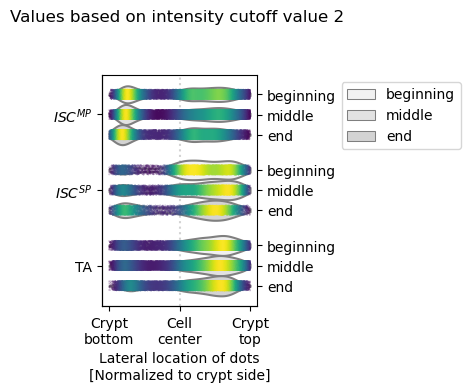

In [30]:
violin_palette = 'Greys'
order = ['ISC', 'Border ISC', 'TA']
time_group_order = ['beginning', 'middle', 'end']
point_order = itertools.product(order, time_group_order)

fig, ax = plt.subplots(figsize = (2, 3))
sbn.violinplot(data = df, y = 'Cell_type', x = values, cut = 0, order = order, hue = 'time_group', hue_order = time_group_order, 
               split = False, inner = None, ax = ax, color = 'lightgray', orient = 'horizontal', scale = 'area')
#sbn.stripplot(data = df, x = 'Cell_type', y = values, hue = 'Frame', order = ['ISC', 'TA'], ax = ax, color = 'k', s = 0.5, dodge = 0.5, jitter = 0.2)
xs = [violin.get_paths()[0].vertices[:, 1].mean() for violin in ax.collections]

x_ix = 0
for cell, time in point_order:
    #print(cell, time, xs[x_ix])
    tmp_df = df.query('Cell_type == @cell & time_group == @time')
    y = tmp_df[values].values
    x = [xs[x_ix]]*len(y)
    magnitude = 800
    x += (np.random.randint(0, 100, size = len(y))-100/2)/magnitude
    c = tmp_df['color_density'].values
    ax.scatter(x = y, y = x, c = c, s = 0.01)
    x_ix+=1
    
[ax.spines[spine].set_visible(False) for spine in ['top', 'right']]

ax.set_xticks([-1, 0, 1], ['Crypt\nbottom', 'Cell\ncenter', 'Crypt\ntop'])
ax.set_yticklabels(['$ISC^{MP}$', '$ISC^{SP}$', 'TA'])
ax.axvline(0, ls = ':', zorder = -10, c = 'lightgray')
ax.set_ylabel('')
ax.set_xlabel('Lateral location of dots\n[Normalized to crypt side]')

twinx = ax.twinx()
twinx.set_ylim(ax.get_ylim())
twinx.set_yticks(np.array(xs), labels = np.array([time_group_order]*len(order)).flatten())

fig.suptitle(f'Values based on intensity cutoff value {cutoff_value}', y = 1.1)
ax.legend(bbox_to_anchor = (1.5,1))
#fig.savefig(os.path.join(main_path, 'Figures', f'Lateral_cutoff2_CombinedTime_3groups_horizontal_dotsWithDensity.pdf'), bbox_inches = 'tight')

In [31]:
res = {}
comparisons = itertools.combinations(df['Cell_type'].unique(), r = 2)
for c1, c2 in comparisons:
    res[(c1, c2)] = {}
    for time in ['beginning', 'middle', 'end']:
        first = list(df.query('Cell_type == @c1 & time_group == @time')[values].values)
        last = list(df.query('Cell_type == @c2 & time_group == @time')[values].values)
        stat, pval = scipy.stats.ks_2samp(first, last)
        res[(c1, c2)][time]=f'{pval:.3f}' if pval > 0.001 else f'{pval:.1e}'

pd.DataFrame.from_dict(res, orient = 'index').reset_index()

,level_0,level_1,beginning,middle,end
0,ISC,Border ISC,1.4e-205,3.6e-196,4.4e-78
1,ISC,TA,0.0e+00,0.0e+00,0.0e+00
2,Border ISC,TA,3.5e-46,9.9e-80,5.1e-49


# Fig 1G

ax = axes[ix]


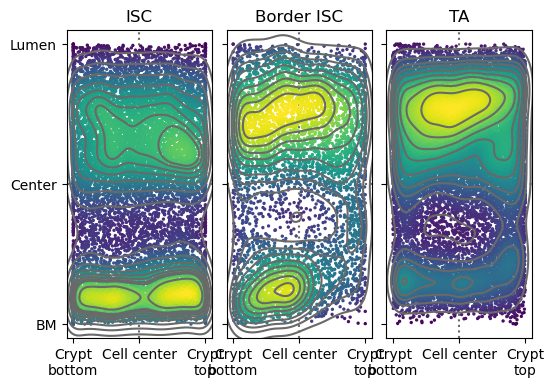

In [37]:
cutoff_value = 2

ncols = 3
fig, axes = initialize_subplots(3, ncols = ncols, figsize_multiplier=(2, 4), gridspec_kw = {'wspace': 0.1, 'hspace': 0.05}, sharex = True, sharey = True)

coordinate_name = 'Normalized_xy_coordinate_in_roi'

for col, cell in enumerate(['ISC', 'Border ISC', 'TA']):
    for row, frame in enumerate(['end']):
        ax = axes[col]
        x, y = zip(*[val for values in comb_df.query('Cell_type == @cell & time_group == @frame').apply(lambda row: get_xy_coords_by_intensity(row), axis = 1).values for val in values])
        finite = np.isfinite(x) & np.isfinite(y)
        x = np.array(x)[finite]
        y = np.array(y)[finite]
        c = calc_density(x, y)
        #x+=(np.random.randint(0, 100, size = len(x))-50)/1000
        #y+=(np.random.randint(0, 100, size = len(y))-50)/1000
        
        ax.scatter(x = x, y = y, s = 2, c = c)
        sbn.kdeplot(x = x, y = y, ax = ax, color = 'dimgray')
        ax.set_ylim([-1.1, 1.1])
        ax.set_xlim([-1.1, 1.1])

        ax.yaxis.set_major_locator(MaxNLocator(nbins = 3, integer = True))
        ax.xaxis.set_major_locator(MaxNLocator(nbins = 3, integer = True))

        ax.set_title(cell)
        
        ax.axvline(0, ls = ':', c = 'dimgray', zorder = -10)
        ax.axhline(0, ls = ':', c = 'dimgray', zorder = -10)
        ax.set_yticks([-1, 0, 1], ['BM', 'Center', 'Lumen'])
        ax.set_xticks([-1, 0, 1], ['Crypt\nbottom', 'Cell center', 'Crypt\ntop'])

#[fig.savefig(os.path.join(main_path, 'Figures', f'Dots_in_Cells_cutoff{cutoff_value}_timeGroupsCombined_3groups_End.{f}', dpi = 600), bbox_inches = 'tight') for f in ['png','pdf']]

ax = axes[ix]


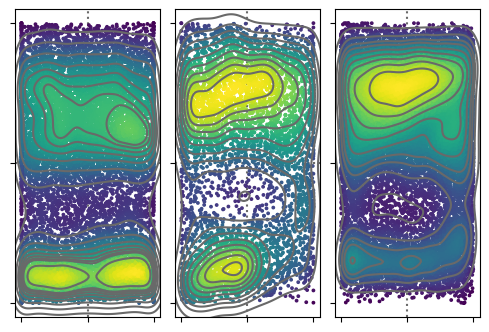

In [38]:
cutoff_value = 2

ncols = 3
fig, axes = initialize_subplots(3, ncols = ncols, figsize_multiplier=(2, 4), gridspec_kw = {'wspace': 0.1, 'hspace': 0.05}, sharex = True, sharey = True)

coordinate_name = 'Normalized_xy_coordinate_in_roi'

for col, cell in enumerate(['ISC', 'Border ISC', 'TA']):
    for row, frame in enumerate(['end']):
        ax = axes[col]
        x, y = zip(*[val for values in comb_df.query('Cell_type == @cell & time_group == @frame').apply(lambda row: get_xy_coords_by_intensity(row), axis = 1).values for val in values])
        finite = np.isfinite(x) & np.isfinite(y)
        x = np.array(x)[finite]
        y = np.array(y)[finite]
        c = calc_density(x, y)
        #x+=(np.random.randint(0, 100, size = len(x))-50)/1000
        #y+=(np.random.randint(0, 100, size = len(y))-50)/1000
        
        ax.scatter(x = x, y = y, s = 3, c = c)
        sbn.kdeplot(x = x, y = y, ax = ax, color = 'dimgray')
        ax.set_ylim([-1.1, 1.1])
        ax.set_xlim([-1.1, 1.1])

        ax.yaxis.set_major_locator(MaxNLocator(nbins = 3, integer = True))
        ax.xaxis.set_major_locator(MaxNLocator(nbins = 3, integer = True))

        ax.set_ylabel('')
        ax.set_xlabel('')

        ax.axvline(0, ls = ':', c = 'dimgray', zorder = -10)
        ax.axhline(0, ls = ':', c = 'dimgray', zorder = -10)
        ax.set_yticks([-1, 0, 1], ['', '', ''])
        ax.set_xticks([-1, 0, 1], ['', '', ''])

#[fig.savefig(os.path.join(main_path, 'Figures', f'Dots_in_Cells_cutoff{cutoff_value}_timeGroupsCombined_3groups_End_NoText.{f}'), bbox_inches = 'tight', dpi = 600) for f in ['png','pdf']]

# Fig S2M

ax = axes[ix // ncols, ix % ncols]


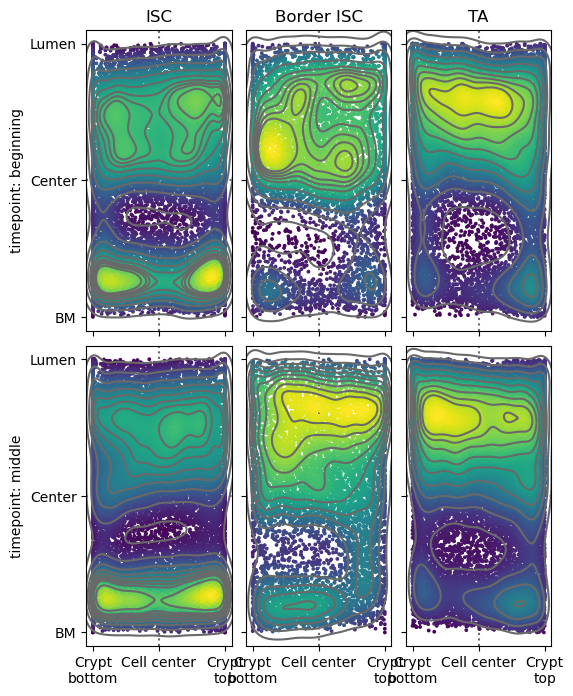

In [42]:
cutoff_value = 2
comb_df['time_group'] = ['beginning' if t < 16 else 'end' if t > 42 else 'middle' for t in comb_df['timepoint']]

ncols = 3
fig, axes = initialize_subplots(6, ncols = ncols, figsize_multiplier=(2, 4), gridspec_kw = {'wspace': 0.1, 'hspace': 0.05}, sharex = True, sharey = True)

coordinate_name = 'Normalized_xy_coordinate_in_roi'

for row, cell in enumerate(['ISC', 'Border ISC', 'TA']):
    for col, frame in enumerate(['beginning', 'middle']):
        ax = axes[col, row]
        x, y = zip(*[val for values in comb_df.query('Cell_type == @cell & time_group == @frame').apply(lambda row: get_xy_coords_by_intensity(row), axis = 1).values for val in values])
        finite = np.isfinite(x) & np.isfinite(y) # 1 value was nan for x coordinate. added this check
        x = np.array(x)[finite]
        y = np.array(y)[finite]
        c = calc_density(x, y)
        #x+=(np.random.randint(0, 100, size = len(x))-50)/1000
        #y+=(np.random.randint(0, 100, size = len(y))-50)/1000
        
        ax.scatter(x = x, y = y, s = 3, c = c)
        sbn.kdeplot(x = x, y = y, ax = ax, color = 'dimgray')
        ax.set_ylim([-1.1, 1.1])
        ax.set_xlim([-1.1, 1.1])

        ax.yaxis.set_major_locator(MaxNLocator(nbins = 3, integer = True))
        ax.xaxis.set_major_locator(MaxNLocator(nbins = 3, integer = True))

        if col == 0:
            ax.set_title(cell)
        if row == 0:
            ax.set_ylabel(f'timepoint: {frame}')

        ax.axvline(0, ls = ':', c = 'dimgray', zorder = -10)
        ax.axhline(0, ls = ':', c = 'dimgray', zorder = -10)
        ax.set_yticks([-1, 0, 1], ['BM', 'Center', 'Lumen'])
        ax.set_xticks([-1, 0, 1], ['Crypt\nbottom', 'Cell center', 'Crypt\ntop'])

#[fig.savefig(os.path.join(main_path, 'Figures', f'Dots_in_Cells_cutoff{cutoff_value}_timeGroupsCombined_3groups_BeginningMiddle.{f}'), bbox_inches = 'tight', dpi = 600) for f in ['png','pdf']]

ax = axes[ix // ncols, ix % ncols]


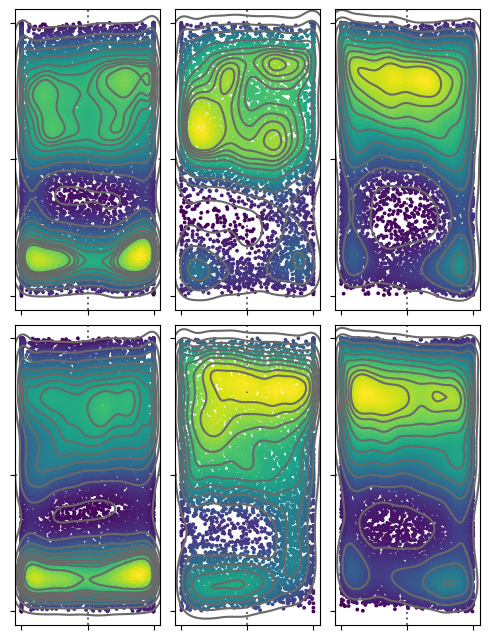

In [41]:
cutoff_value = 2
comb_df['time_group'] = ['beginning' if t < 16 else 'end' if t > 42 else 'middle' for t in comb_df['timepoint']]

ncols = 3
fig, axes = initialize_subplots(6, ncols = ncols, figsize_multiplier=(2, 4), gridspec_kw = {'wspace': 0.1, 'hspace': 0.05}, sharex = True, sharey = True)

coordinate_name = 'Normalized_xy_coordinate_in_roi'

for row, cell in enumerate(['ISC', 'Border ISC', 'TA']):
    for col, frame in enumerate(['beginning', 'middle']):
        ax = axes[col, row]
        x, y = zip(*[val for values in comb_df.query('Cell_type == @cell & time_group == @frame').apply(lambda row: get_xy_coords_by_intensity(row), axis = 1).values for val in values])
        finite = np.isfinite(x) & np.isfinite(y) # 1 value was nan for x coordinate. added this check
        x = np.array(x)[finite]
        y = np.array(y)[finite]
        c = calc_density(x, y)
        #x+=(np.random.randint(0, 100, size = len(x))-50)/1000
        #y+=(np.random.randint(0, 100, size = len(y))-50)/1000
        
        ax.scatter(x = x, y = y, s = 3, c = c)
        sbn.kdeplot(x = x, y = y, ax = ax, color = 'dimgray')
        ax.set_ylim([-1.1, 1.1])
        ax.set_xlim([-1.1, 1.1])

        ax.yaxis.set_major_locator(MaxNLocator(nbins = 3, integer = True))
        ax.xaxis.set_major_locator(MaxNLocator(nbins = 3, integer = True))

        ax.set_ylabel('')
        ax.set_xlabel('')

        ax.axvline(0, ls = ':', c = 'dimgray', zorder = -10)
        ax.axhline(0, ls = ':', c = 'dimgray', zorder = -10)
        ax.set_yticks([-1, 0, 1], ['', '', ''])
        ax.set_xticks([-1, 0, 1], ['', '', ''])

#[fig.savefig(os.path.join(main_path, 'Figures', f'Dots_in_Cells_cutoff{cutoff_value}_timeGroupsCombined_3groups_BeginningMiddle_NoText.{f}'), bbox_inches = 'tight', dpi = 600) for f in ['png','pdf']]

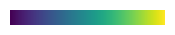

In [902]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(1,1,figsize = (2, 0.2))
ax.imshow(gradient, cmap = mpl.colormaps['viridis'], aspect = 'auto')
ax.set_axis_off()
#[fig.savefig(os.path.join(main_path, 'Figures', f'Dots_in_Cells_colormap.{f}'), bbox_inches = 'tight', dpi = 600) for f in ['png','pdf']]